In [1]:
import csv
import json
import time
import sys
import re
import pandas as pd
from urllib import request, parse, robotparser, error
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from scipy.stats import gaussian_kde
from pathlib import Path
import backboning
from backboning import high_salience_skeleton



# Preparing Data 

### Load data

Loading the scraped data, which is stored in a csv file from the scraping process. See the notebook Data_scarping.ipynb.

In [2]:
# Scraped data
data = pd.read_csv("bbc_food_recipes.csv")

# Load food list from Excel
food_list = pd.read_excel("Frida_Dataset_May2025.xlsx", sheet_name="Data_Table", skiprows=1)

food_list_units = food_list.iloc[0]

# Remove rows 0 and 1, reset index, and rename first three columns
food_list = (food_list.drop(index=[0, 1])
             .reset_index(drop=True)
             .rename(columns={food_list.columns[0]: "Food_Danish",
                            food_list.columns[1]: "Food_English",
                            food_list.columns[2]: "Food_ID"}))

# Extract first part before comma from Food_English and get unique values
single_food_list = list(set(item.split(',')[0] for item in food_list['Food_English']))

# Add additional ingredients
single_food_list.extend(['mushrooms', 'white wine', 'red wine', 'caster sugar', 
                        'chicken stock', 'vegetable stock', 'beef stock', 'basil', 
                        'oregano', 'thyme', 'rosemary', 'parmasan', 'mozzarella'])

### Extract clean list of ingredients
Cleaning the data and generating of a new column for cleaned ingredients. Common words and units are filtered out.

In [3]:
def extract_ingredients(ingredient_string, food_list):
    """Extract and clean ingredients from a string, matching against a food list."""
    
    # Normalize string
    text = ingredient_string.replace(',', '').replace(' || ', ',').lower()
    ingredients = text.split(',')
    
    # Helper function to remove plural endings
    def singularize(word):
        if word.endswith('ies'):
            return word[:-3] + 'y'
        elif word == 'sausages' or word == 'sausage':
            return 'sausage'
        elif word.endswith('es'):
            return word[:-2]
        elif word.endswith('s'):
            return word[:-1]

        return word
    
    # Words to combine with previous word
    combiners = {'oil', 'sugar', 'wine', 'purée', 'stock'}
    
    # Words to filter out
    units = {'kg', 'g', 'mg', 'l', 'ml', 'tsp', 'tbsp', 'cup', 'cups', 'oz', 'lb', 
             'pint', 'quart', 'dash', 'pinch', 'clove', 'cloves', 'slice', 'slices', 
             'can', 'cans', 'bunch', 'bunches'}
    common = {'of', 'fresh', 'chopped', 'diced', 'minced', 'ground', 'large', 'small', 
              'medium', 'to', 'taste', 'and', 'x', 'piece', 'pieces', 'packet', 
              'packets', 'bottle', 'bottles', 'jar', 'jars', 'bag', 'bags'}
    
    # Create lowercase version of food_list once
    food_list_lower = {f.lower() for f in food_list}
    
    clean_list = []
    
    for ingredient in ingredients:
        words = [singularize(w) for w in ingredient.split()]
        
        # Combine special words with previous word
        combined = []
        for i, word in enumerate(words):
            if word in combiners and combined:
                combined[-1] = f"{combined[-1]} {word}"
            elif word:
                combined.append(word)
        
        # Filter out units and common words
        filtered = [w for w in combined if w not in units and w not in common]
        
        # Match against food list
        for word in filtered:
            word = word.replace('tomato purée', 'tomato puree')
            if word in food_list_lower:
                clean_list.append(word)
    
    return list(set(clean_list))

In [4]:
# Make new column with cleaned ingredients
clean_ingredients = []

for ing in data['ingredients']:
    clean_list = extract_ingredients(ing, single_food_list)
    clean_ingredients.append(clean_list)

data['clean_ingredients'] = clean_ingredients

In [5]:
## Remove certain ingredients from the list
remove_ingredients = ['salt', 'pepper']
data['final_ingredients'] = data['clean_ingredients'].apply(
    lambda lst: [item for item in lst if item not in remove_ingredients]
)

In [6]:
## Basic statistics
print(f'Total recipes scraped: {len(data)}')
print(f'Total unique ingredients: {len(set(item for sublist in data["final_ingredients"] for item in sublist))}')

Total recipes scraped: 445
Total unique ingredients: 152


In [7]:
## Most common ingredients
all_ingredients = [item for sublist in data['final_ingredients'] for item in sublist]
ingredient_counts = Counter(all_ingredients)
print(f'The 10 most common ingredients are: {ingredient_counts.most_common(10)}')
print(f'The 10 least common ingredients are: {ingredient_counts.most_common()[-10:]}')

The 10 most common ingredients are: [('garlic', 207), ('onion', 206), ('olive oil', 165), ('butter', 150), ('egg', 146), ('tomato', 114), ('chicken', 111), ('lemon', 96), ('coriander', 94), ('sauce', 93)]
The 10 least common ingredients are: [('soup', 1), ('vermouth', 1), ('vodka', 1), ('hake', 1), ('turnip', 1), ('shrimp', 1), ('bouillon', 1), ('watermelon', 1), ('duck', 1), ('tea', 1)]


### Initial exploration of data

To get insights from the data, and what to include in the analysis.

#### Disbribution of number of ingredients per recipe

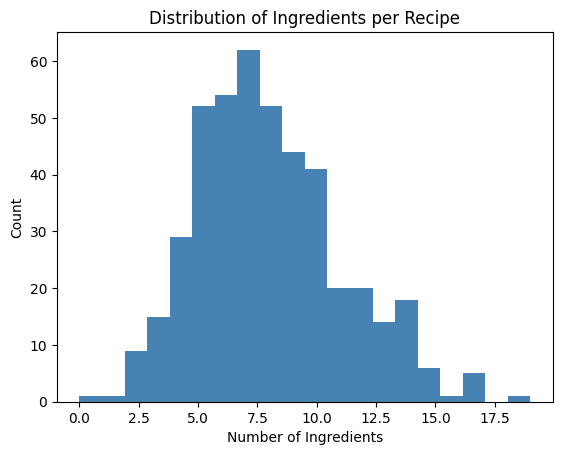

In [8]:
# Plot distribution of number of ingredients per recipe
plt.hist(data['final_ingredients'].apply(len), bins=20, color='steelblue',)
plt.xlabel('Number of Ingredients')
plt.ylabel('Count')
plt.title('Distribution of Ingredients per Recipe')
plt.show()


This plot shows how many ingredients recipes typically use. The distribution of ingredient counts is roughly bell-shaped, with most recipes containing between 5 and 10 ingredients, with very few using fewer than 3 or more than 15. This tells us that ingredient count is a stable and well-behaved feature in the dataset. Because of this, it could be a useful variable to explore further when deciding how to compare recipes or identify patterns in the data.

#### Top 20 most common ingredients

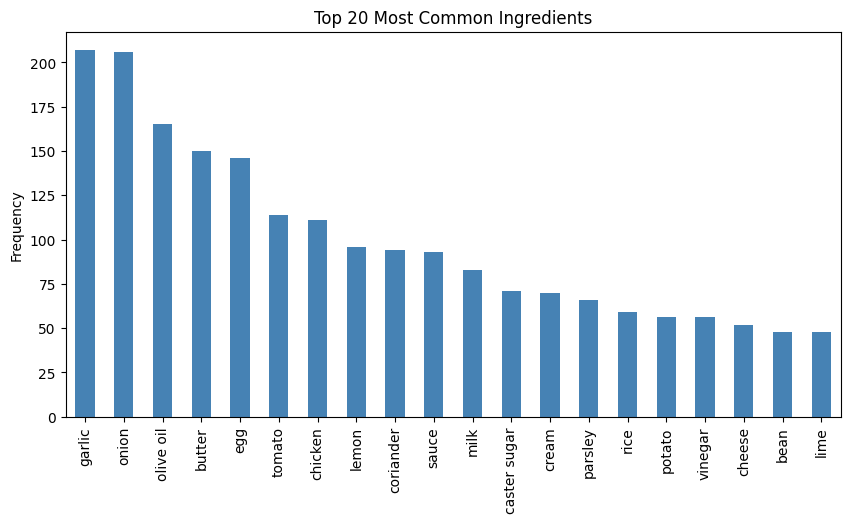

In [9]:
all_ing = Counter([i for recipe in data['final_ingredients'] for i in recipe])
pd.Series(all_ing).nlargest(20).plot(kind='bar', figsize=(10,5), color='steelblue',)
plt.title('Top 20 Most Common Ingredients')
plt.ylabel('Frequency')
plt.show()


To get a better overview of the ingredients, the top 20 most common ingredients have been plotted. Salt and pepper were removed earlier since they appear in almost every salty dish. In the plot we see that a few ingredients, such as garlic, onion, and olive oil, appear very frequently across recipes, while the remaining ingredients occur less often. This suggests that some ingredients are shared widely throughout the dataset, which could later influence how similar recipes are to each other.

#### Distributions of ratings and number of reviews

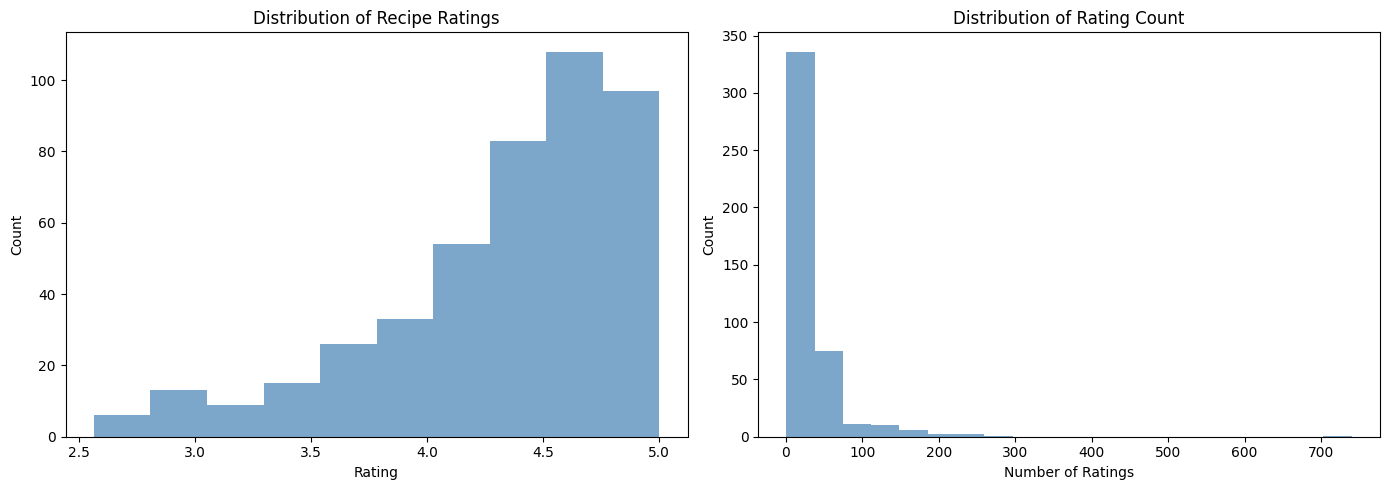

In [10]:
# Rating distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Rating values ---
axes[0].hist(data['ratingValue'], bins=10, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Recipe Ratings')

# --- Right: Rating counts ---
axes[1].hist(data['ratingCount'], bins=20, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Rating Count')

plt.tight_layout()
plt.show()


The plot on the left shows the distribution of recipe ratings. Most ratings are between 4.0 and 5.0, which means the dataset is skewed toward generally well-liked recipes. However, there are still a significant number of recipes with lower ratings, indicating some diversity in user opinions. This suggests that while many recipes are popular, there is still room to explore what makes certain recipes less favored.

The plot on the right shows how many ratings each recipe has received. Here the distribution is extremely uneven: many recipes have only a few number of ratings, while a small number have very many. Because of this large variation and the fact that most recipes have low rating counts, it may not be reasonable to use rating count as an explanatory measure.

#### Comparison of cooking time vs number of ingredients

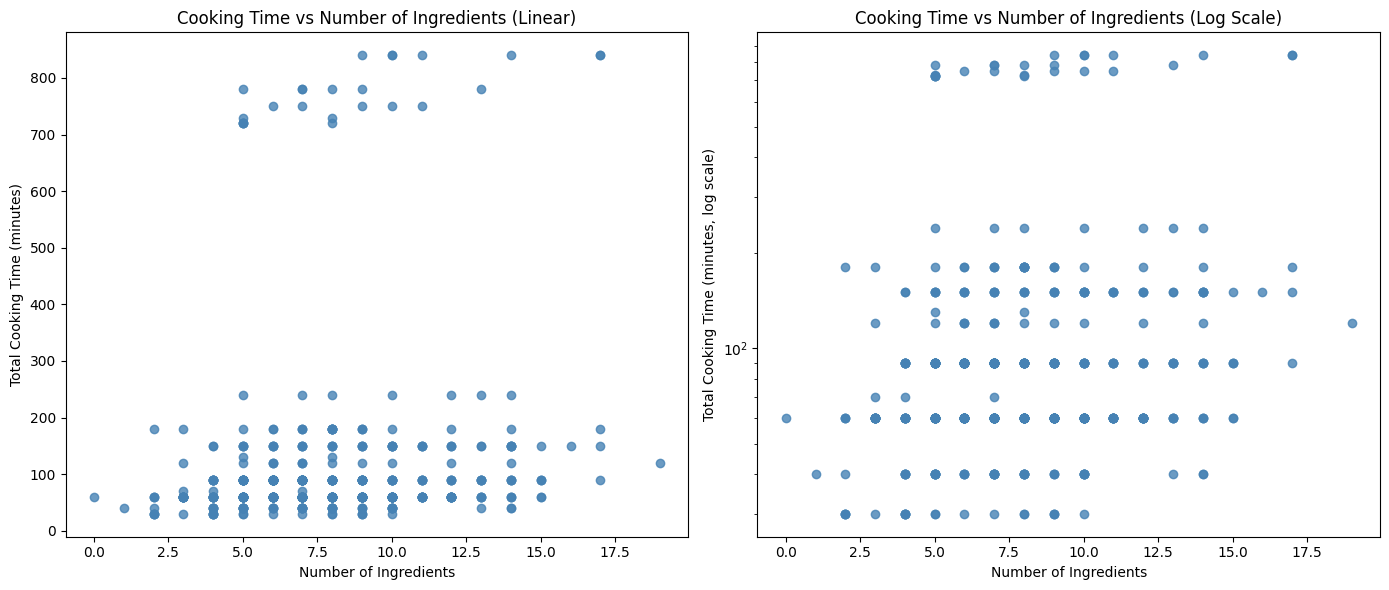

In [11]:
## Total time vs number of ingredients

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# --- Left plot: normal scale ---
axes[0].scatter(data['final_ingredients'].apply(len), data['total_time_min'], alpha=0.8, color='steelblue')
axes[0].set_title('Cooking Time vs Number of Ingredients (Linear)')
axes[0].set_xlabel('Number of Ingredients')
axes[0].set_ylabel('Total Cooking Time (minutes)')

# --- Right plot: log scale ---
axes[1].scatter(data['final_ingredients'].apply(len), data['total_time_min'], alpha=0.8, color='steelblue')
axes[1].set_yscale('log')
axes[1].set_title('Cooking Time vs Number of Ingredients (Log Scale)')
axes[1].set_xlabel('Number of Ingredients')
axes[1].set_ylabel('Total Cooking Time (minutes, log scale)')

plt.tight_layout()
plt.show()


This scatter plot compares the number of ingredients in a recipe with its total cooking time. At first glance, one might expect that recipes with more ingredients take longer to cook.

Although it is tempting to investigate whether recipes with more ingredients take longer to cook, the scatter plot shows no meaningful relationship between ingredient count and total cooking time. Recipes with the same number of ingredients vary a lot in cooking time, and some recipes take many hours for reasons unrelated to how many ingredients they have. Since cooking time and ingredient count do not relate to the structure of the ingredient network and do not help explain the communities or the sentiment results, we do not include these measures in the main analysis.

# Network

Based on the initial exploration, we now construct a recipe network.
In this network, each recipe is represented by a node, and an edge is created between two recipes if they share ingredients. The edges are weighted by how many ingredients the two recipes have in common. To avoid linking recipes that only overlap by chance, we only create an edge when two recipes share at least three ingredients.

In [12]:
## Create graph with recipes as nodes and ingredients as edges add weight based on number of shared ingredients
G_recipes = nx.Graph()
for idx, row in data.iterrows():
    G_recipes.add_node(row['title'],ratingValue=row['ratingValue'],
        ratingCount=row['ratingCount'])

for idx1, row1 in data.iterrows():
    for idx2, row2 in data.iterrows():
        if idx1 != idx2:
            common_ingredients = set(row1['final_ingredients']).intersection(set(row2['final_ingredients']))
            
            # Add edge if 3 or more ingredients are shared amd add weight
            if len(common_ingredients) >= 3:
                if G_recipes.has_edge(row1['title'], row2['title']):
                    G_recipes[row1['title']][row2['title']]['weight'] += len(common_ingredients)
                else:
                    G_recipes.add_edge(row1['title'], row2['title'], weight=len(common_ingredients),shared_ingredients=list(common_ingredients))

print(f'The number of nodes in the recipe graph is: {G_recipes.number_of_nodes()}')
print(f'The number of edges in the recipe graph is: {G_recipes.number_of_edges()}')

The number of nodes in the recipe graph is: 445
The number of edges in the recipe graph is: 19469


With 445 nodes and 19,469 edges, the recipe network is quite dense. This indicates that many recipes share enough ingredients to form connections, which aligns with our earlier observation that several ingredients appear frequently across the dataset.

Before constructing the network, it can be useful to check how often certain ingredient combinations occur.

In [13]:
## Find recipe containing specific ingredients
target_ingredients = {'chocolate', 'apple'}

matching_recipes = []
for idx, row in data.iterrows():
    if target_ingredients.issubset(set(row['final_ingredients'])):
        matching_recipes.append((row['title'], row['url']))

print(f"Recipes containing {target_ingredients}:")
for title, url in matching_recipes:
    print(f"- {title}: {url}")

Recipes containing {'chocolate', 'apple'}:
- Gluten-free cupcakes with tahini icing: https://www.bbc.co.uk/food/recipes/buckwheat_and_butternut_60078


For quick overview of the constructed network, the network is plotted.

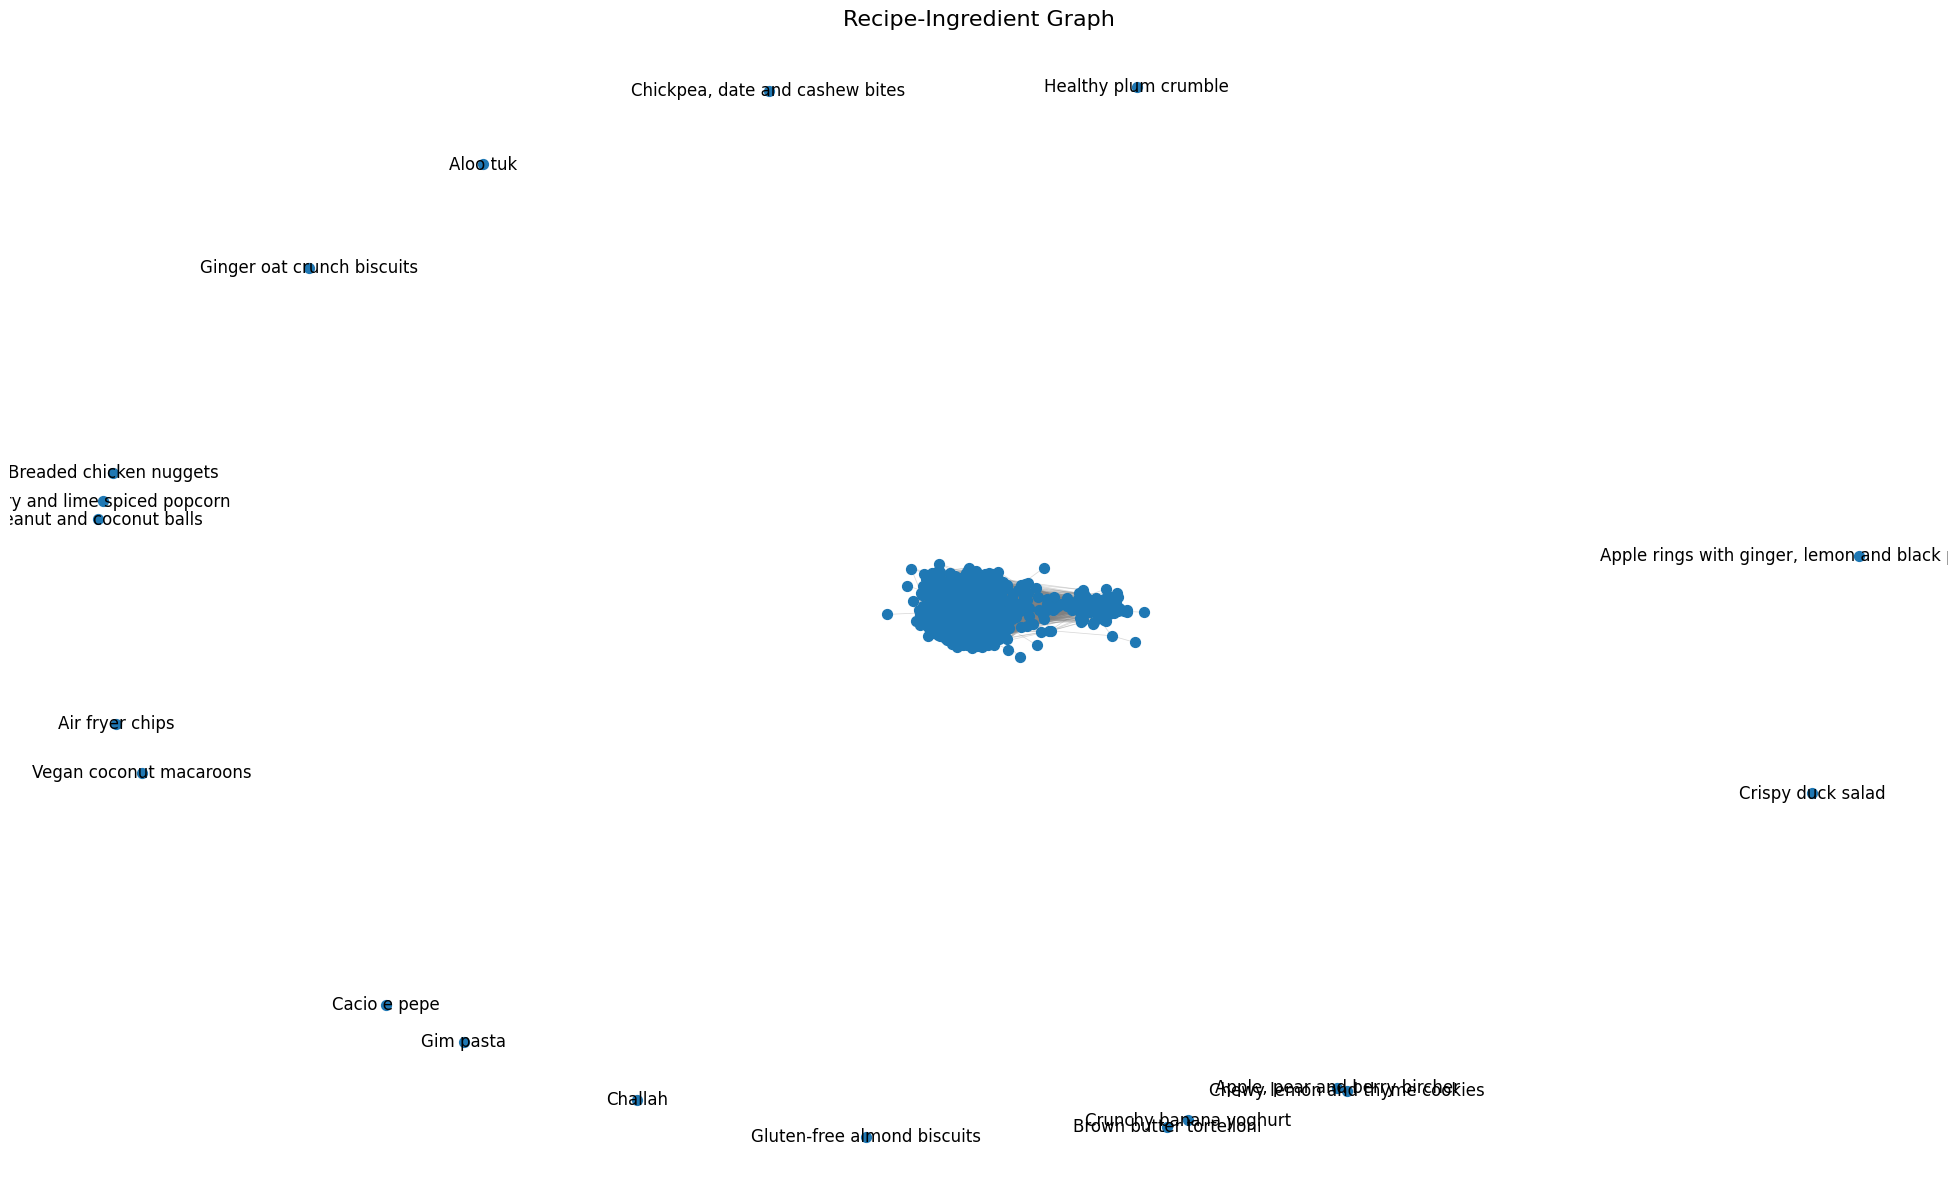

In [14]:
plt.figure(figsize=(25, 15))
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)

# Draw nodes 
nx.draw_networkx_nodes(G_recipes, pos, node_size=50)

# draw labels for a isolated nodes only
isolated_nodes = [node for node in G_recipes.nodes() if G_recipes.degree(node) == 0]
nx.draw_networkx_labels(G_recipes, pos, labels={node: node for node in isolated_nodes}, font_size=12)

# Compute edge widths based on weight (but scaled down)
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])
edge_widths = edge_widths / edge_widths.max() * 2  # normalize to max width ~2

# Draw edges with transparency and lighter color
nx.draw_networkx_edges(
    G_recipes,
    pos,
    width=edge_widths,
    edge_color="gray",   
    alpha=0.3             
)

plt.title("Recipe-Ingredient Graph", fontsize=16)
plt.axis("off")
plt.show()


The network visualization shows one large connected cluster of recipes and several isolated recipes that do not share enough ingredients with any others. These isolated recipes are labeled in the figure. The main cluster indicates that most recipes are linked through shared ingredients, while the isolated ones reflect more unique, specialized recipes or few number of ingredients.

## Network statistics

To analyze how the recipes are connected, we use standard network statistics. We look at degree, centrality, and assortativity to get a better understanding of the overall structure of the network.

In [15]:
## Degree distributions
degree_sequence = [d for n, d in G_recipes.degree()]
degree_count = Counter(degree_sequence)
deg, cnt = zip(*sorted(degree_count.items()))

mean_degree = np.mean(degree_sequence)
median_degree = np.median(degree_sequence)
print(f'Mean degree: {mean_degree}')
print(f'Median degree: {median_degree}\n')

# Top 5 recipes sharing most ingredients
top_5_recipes = sorted(G_recipes.degree(), key=lambda x: x[1], reverse=True)[:5]
for recipe, degree in top_5_recipes:
    print(f'{recipe}: {degree}')

Mean degree: 87.50112359550562
Median degree: 77.0

Breakfast burrito: 305
Cheese and onion quiche: 234
Beetroot and goats’ cheese risotto: 232
Vegan burgers: 229
Caribbean chicken with rice and peas: 222


The network has a mean degree of about 87 and a median degree of 77, which shows that most recipes are connected to many others through shared ingredients. The mean is higher than the median, indicating a few recipes have very high degrees and pull the average upward. These highly connected recipes act as hubs in the network.

Examples include Breakfast burrito, Cheese and onion quiche, and Beetroot and goats’ cheese risotto. Their high degrees suggest that they contain common ingredients that appear across many different recipes.

In [16]:
## Print all elements of a specific recipe 
for col in ['ingredients', 'clean_ingredients', 'final_ingredients']:
    print(f"\n{col} for 'Breakfast burrito':")
    print( data[data['title'] == 'Breakfast burrito'][col].values[0] )

len(data[data['title'] == 'Breakfast burrito']['final_ingredients'].values[0])



ingredients for 'Breakfast burrito':
60g/2¼oz mature cheddar, grated || salt and freshly ground black pepper || 100g/3½oz dried black beans, soaked overnight in cold water || 1 onion, halved || 1 dried ancho chilli || 2 garlic cloves, finely chopped || 45g/1¾oz lard || 175g/6oz plain flour, plus extra for dusting || 35g/1¼oz cornmeal or polenta || 1 tsp baking powder || 150ml/5fl oz warm water || 2 large tomatoes, flesh finely chopped, juice and seeds drained || ½ tsp caster sugar || ½ lime, juice only || 1½ large avocados, roughly chopped || 1 large red hot chilli, finely chopped || 2 tsp chopped fresh coriander || ½ lime, juice only || 1 tsp olive oil || 2 sun-dried tomatoes, finely chopped || 1 jalapeño chilli, finely chopped || 100ml/3½fl oz soured cream || 1½ tsp olive oil || 200g/7oz spicy cooking chorizo, roughly chopped || 5 chestnut mushrooms, roughly chopped || 2–3 tbsp chipotle sauce || 40g/1½oz butter || 4 large free-range eggs

clean_ingredients for 'Breakfast burrito':
[

17

To better understand this, the core ingredients for the Breakfast burrito are printed, and most of them are among the popular ingredients seen in the exploratory plot of top ingredients. Also it ends up with 17 final ingredients, which helps explain why it is one of the most highly connected recipes in the network.

### Degree distributions

Next, we want to investigate if the network have random or scale-free properties by comparing degree distributions

In [17]:
## Degree distributions

# Compute degrees
degrees = [d for n, d in G_recipes.degree()]

# Generate multiple random networks and aggregate degrees
n_samples = 50
random_degrees_all = []
for _ in range(n_samples):
    Gr_temp = nx.gnm_random_graph(G_recipes.number_of_nodes(), G_recipes.number_of_edges())
    random_degrees_all.extend([d for n, d in Gr_temp.degree()])

# Generate multiple scale-free networks and aggregate degrees
avg_degree = int(2 * G_recipes.number_of_edges() / G_recipes.number_of_nodes())
m = max(1, avg_degree // 2)

scale_degrees_all = []
for _ in range(n_samples):
    Gs_temp = nx.barabasi_albert_graph(G_recipes.number_of_nodes(), m=m)
    scale_degrees_all.extend([d for n, d in Gs_temp.degree()])

# KDE for random and scale-free networks
max_degree = max(max(degrees), max(random_degrees_all), max(scale_degrees_all))
x_range = np.linspace(0, max_degree, 300)

kde_random = gaussian_kde(random_degrees_all)
kde_scale = gaussian_kde(scale_degrees_all)
random_pdf = kde_random(x_range)
scale_pdf = kde_scale(x_range)

# Histogram parameters with explicit bin edges for integer degrees
min_degree = min(degrees)
max_degree = max(degrees)
bin_edges = np.arange(min_degree, max_degree + 2) - 0.5  # Bins centered on integers
num_bins = len(bin_edges) - 1
bin_width = 1  # Each bin is exactly 1 degree wide

n_samples = len(degrees)

# Scale KDE to match histogram counts
random_counts = random_pdf * n_samples * bin_width
scale_counts = scale_pdf * n_samples * bin_width

# Plot
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=degrees,
    xbins=dict(
        start=bin_edges[0],
        end=bin_edges[-1],
        size=1  # Bin width of 1 degree
    ),
    marker_color='steelblue',
    marker_line_color='white',
    marker_line_width=1,
    opacity=0.6,
    name="Recipe network"
))

# --- Mean & median vertical lines ---
fig.add_vline(x=mean_degree, line_dash="dash", line_color="red",
              annotation_text="Mean", annotation_position="top right")

fig.add_vline(x=median_degree, line_dash="dot", line_color="green",
              annotation_text="Median", annotation_position="top left")

fig.add_trace(go.Scatter(
    x=x_range,
    y=random_counts,
    mode='lines',
    name="Random network (50 nets)",
    line=dict(width=3, color='seagreen')
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=scale_counts,
    mode='lines',
    name="Scale-free network (50 nets)",
    line=dict(width=3, color='darkorange')
))

fig.update_layout(
    width=900, height=500,
    title_text="Degree Distribution",
    xaxis_title="Degree",
    yaxis_title="Count",
    template="plotly_white",
    legend=dict(x=0.8, y=0.95)
)

fig.show()

The degree distribution does not match either a random or a scale-free network. This suggests that new recipes connect based on the ingredients they use rather than random or preferential attachment. After this, we remove isolated nodes, since recipes with no connections cannot contribute to the network structure we want to analyze.

In [18]:
# map degree to data
degree_map = dict(G_recipes.degree())
data['degree'] = data['title'].map(degree_map)

In [19]:
# remove isolated nodes
isolated_nodes = list(nx.isolates(G_recipes))
G_recipes.remove_nodes_from(isolated_nodes)

print(f'The number of nodes in the recipe graph after removing isolated nodes is: {G_recipes.number_of_nodes()}')

The number of nodes in the recipe graph after removing isolated nodes is: 426


After removing the isolated recipes, 426 nodes remain in the network, menaing we are not missing out on much information by excluding them.

To get a sense of how strongly recipes are connected, we can look at a few example edges and their weights. The weight shows how many ingredients two recipes share.

In [20]:
# Print subset of edges with weights
for u, v, d in list(G_recipes.edges(data=True))[-10:]:
    print(f"{u} - {v}: {d['weight']}")

Air fryer harissa chicken with herby couscous - Bún chả inspired noodle bowl: 6
Air fryer harissa chicken with herby couscous - Easy chicken and chorizo rice: 6
Air fryer harissa chicken with herby couscous - Chicken fajita bowl: 6
Air fryer harissa chicken with herby couscous - Creamy mushroom chicken: 8
Bún chả inspired noodle bowl - Easy chicken and chorizo rice: 8
Bún chả inspired noodle bowl - Chicken fajita bowl: 10
Bún chả inspired noodle bowl - Creamy mushroom chicken: 6
Easy chicken and chorizo rice - Chicken fajita bowl: 8
Easy chicken and chorizo rice - Creamy mushroom chicken: 10
Chicken fajita bowl - Creamy mushroom chicken: 6


This shows that some recipe pairs share between 6 and 10 ingredients, which indicates fairly strong connections. These higher weights reflect recipes that use many of the same common ingredients and therefore appear close to each other in the network.

### Centrality
We calculate the different centralities to get insight of the network representation of the recipes and their ingredients.

In [21]:
## Please calculate the 5 most central nodes according to degree centrality, betweenness centrality, and eigenvector centrality.
degree_centrality = nx.degree_centrality(G_recipes)
betweenness_centrality = nx.betweenness_centrality(G_recipes)
eigenvector_centrality = nx.eigenvector_centrality(G_recipes, max_iter=1000)

## Visualizing the betweenness centrality of nodes vs degree centrality and the eigenvector centrality in a subplot using plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=('Degree vs Betweenness Centrality', 'Degree vs Eigenvector Centrality'))
fig.add_trace(go.Scatter(x=list(betweenness_centrality.values()), y=list(degree_centrality.values()),
                         mode='markers', name='Degree Centrality vs Betweenness Centrality',
                         marker=dict(color='blue', size=8, opacity=0.6)),
              row=1, col=1)
fig.add_trace(go.Scatter(x=list(eigenvector_centrality.values()), y=list(degree_centrality.values()),
                         mode='markers', name='Degree Centrality vs Eigenvector Centrality',
                         marker=dict(color='orange', size=8, opacity=0.6)),
                row=1, col=2)
fig.update_xaxes(title_text='Betweenness Centrality', row=1, col=1) #, type='log')
fig.update_yaxes(title_text='Degree Centrality', row=1, col=1) #, type='log')
fig.update_xaxes(title_text='Eigenvector Centrality', row=1, col=2) #, type='log')
fig.update_yaxes(title_text='Degree Centrality', row=1, col=2) #, type='log')
fig.update_layout(title_text='Centrality Measures Comparison', showlegend=False, 
                  width=1200, height=500)
fig.show()

The plots compare degree centrality with betweenness and eigenvector centrality. We see that degree and betweenness are not strongly related, meaning a recipe can have many connections without being important for paths in the network. In contrast, degree and eigenvector centrality increase together, meaning recipes with many connections are often linked to other well-connected recipes.

### Assortativity

In [22]:
# Compute degree assortativity
r = nx.degree_assortativity_coefficient(G_recipes)
print(f"Degree assortativity: {r:.4f}")

# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, "ratingValue")
print(f"Assortativity (ratingValue): {r:.5f}")

# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, "ratingCount")
print(f"Assortativity (ratingCount): {r:.4f}")

Degree assortativity: 0.0720
Assortativity (ratingValue): -0.00332
Assortativity (ratingCount): -0.0029


The degree assortativity of the network is close to zero. This indicates that there is little or no correlation between highly connected nodes being linked to other highly connected nodes. that is, if a recipe shares ingredients with many other recipes, it does not mean that these recipes also are linked to many. likewise the other way aroud

Similarly, the assortativity based on rating value and rating count is slightly negative but still very close to zero. This shows no meaningful tendency for recipes with similar ratings or similar numbers of ratings to share ingredients with each other. If assortativity in these attributes had been high, it would suggest that ingredient choice influences these recipe characteristics. Instead, the near-zero values imply that ingredient overlap does not systematically relate to how highly a recipe is rated or how many users chose to rate it.


Overall, the network shows no strong assortative or disassortative patterns, implying that connections are largely random with respect to both degree and content length.


### Backbone

The full recipe network has many edges, and some of them are not very important. To focus on the stronger and more meaningful connections, we create a backbone of the network. This helps us see the main structure more clearly. We visualize the backbone of the network using different methods such as disparity filter and HSS

In [23]:
# Network 1: The recipe network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality 
# (renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
G1 = G_recipes.copy()
bet_centrality = nx.edge_betweenness_centrality(G1)
max_eb = max(bet_centrality.values())
min_eb = min(bet_centrality.values())

for u, v in G1.edges():
    eb = bet_centrality[(u, v)]
    # Normalize to range [1, 100]
    weight = 1 + (eb - min_eb) / (max_eb - min_eb) * 99
    G1[u][v]['weight'] = weight

# Network 2: edge weights proportional to 1/(edge weight in Weighted Network 1).
G2 = G1.copy()
for u, v in G2.edges():
    weight = G1[u][v]['weight']
    G2[u][v]['weight'] = 1 / weight if weight > 0 else 0

In [24]:
# Network 3, made with help from LLM as allowed in the exercise instructions
rows = []
for u, v, edge_data in G2.edges(data=True):
    cost = float(edge_data.get("weight", 1.0))
    if cost <= 0:             # avoid zero/negative costs
        cost = 1e-9
    rows.append((u, v, cost))

table = pd.DataFrame(rows, columns=["src", "trg", "nij"])  # HSS expects a weight column; name 'nij' is fine

# Run HSS (aggregate undirected)
hss_df = high_salience_skeleton(table, undirected=True, return_self_loops=False)

# Inspect distribution & pick a data-driven threshold
scores = hss_df["score"].to_numpy()

# Keep the top 10% by salience, but never fewer than 1 edge
pct = 0.90
thr = np.quantile(scores, pct) if len(scores) > 10 else np.max(scores)
# If that's still too strict (all below thr due to ties), relax progressively
if (scores >= thr).sum() == 0:
    for p in (0.80, 0.70, 0.60, 0.50, 0.40, 0.30):
        thr = np.quantile(scores, p)
        if (scores >= thr).sum() > 0:
            break

keep = hss_df[hss_df["score"] >= thr]

# Build G3, preserving original distances and adding salience
G3 = nx.Graph()
G3.add_nodes_from(G2.nodes(data=True))

for _, row in keep.iterrows():
    u, v = row["src"], row["trg"]
    sal = float(row["score"])
    # Grab original attributes in either orientation
    data_uv = G2.get_edge_data(u, v)
    if data_uv is None and G2.is_directed():
        data_uv = G2.get_edge_data(v, u)
    data_back = dict(data_uv) if data_uv else {}
    data_back["salience"] = sal
    G3.add_edge(u, v, **data_back)
    
print(
    f"G3: {G3.number_of_nodes()} nodes, {G3.number_of_edges()} edges "
    f"(threshold={thr:.3f}, kept={len(keep)}/{len(hss_df)} ~ {len(keep)/max(1,len(hss_df)):.1%})")

Calculating HSS score...


G3: 426 nodes, 1972 edges (threshold=0.302, kept=1972/19469 ~ 10.1%)


In [25]:
# Get backboning to work correctly with pandas 2.x
bb_path = Path(r"backboning.py")

src = bb_path.read_text(encoding="utf-8")

# Replace old .drop("col", 1) with .drop(columns=["col"])
src = re.sub(r'\.drop\(\s*"edge"\s*,\s*1\s*\)', '.drop(columns=["edge"])', src)
src = re.sub(r'\.drop\(\s*"score_min"\s*,\s*1\s*\)', '.drop(columns=["score_min"])', src)
src = re.sub(r'\.drop\(\s*"variance_max"\s*,\s*1\s*\)', '.drop(columns=["variance_max"])', src)

bb_path.write_text(src, encoding="utf-8")
print("Patched backboning.py for pandas 2.x compatibility.")

Patched backboning.py for pandas 2.x compatibility.


In [26]:
def disparity_backbone(G, alpha=0.1, top_q=0.95, undirected=True):
    """
    Returns the largest-component backbone of G using the disparity filter.
    alpha: significance threshold for alpha/p columns (loosen to e.g. 0.15 if too sparse)
    top_q: keep top quantile if the filter returns 'score' (e.g., 0.9 keeps top 10%)
    """
    # Build (src, trg, nij) table
    tbl = pd.DataFrame(
        ((u, v, float(d.get("weight", 1.0))) for u, v, d in G.edges(data=True)),
        columns=["src", "trg", "nij"],
    )
    df = backboning.disparity_filter(tbl, undirected=undirected)

    # Pick significance column and keep edges
    sig = next((c for c in ("alpha", "p", "score") if c in df.columns), None)
    if sig is None:
        raise ValueError(f"No significance column found. Got: {df.columns.tolist()}")

    if sig in ("alpha", "p"):
        keep = df.loc[df[sig].le(alpha), ["src", "trg", "nij"]]
    else:
        thr = df[sig].quantile(top_q)
        keep = df.loc[df[sig].ge(thr), ["src", "trg", "nij"]]

    # Build backbone graph and keep the largest connected component (if any)
    B = nx.from_pandas_edgelist(keep, "src", "trg", edge_attr="nij", create_using=nx.Graph())
    if B.number_of_edges():
        B = B.subgraph(max(nx.connected_components(B), key=len)).copy()
    return B, sig

# ---- Plot helper: size by (unweighted) degree, hide isolates ----
def plot_backbone(B, title, sig_label, figsize=(10, 6)):
    if B.number_of_nodes() == 0:
        print(f"{title}: backbone is empty at current settings.")
        return
    # remove isolates if any (aesthetics)
    B = B.subgraph([n for n in B.nodes if B.degree(n) > 0]).copy()
    pos = nx.forceatlas2_layout(B, max_iter=600)
    deg = dict(B.degree())
    sizes = [10 + 2*deg[n] for n in B.nodes()]  # scale as you wish

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(B, pos, node_size=sizes, node_color="darkslateblue")
    nx.draw_networkx_edges(B, pos, alpha=0.85, width=1.0, edge_color="gray")
    plt.title(f"{title} (kept by {sig_label})")
    plt.axis("off")
    plt.show()

Calculating DF score...


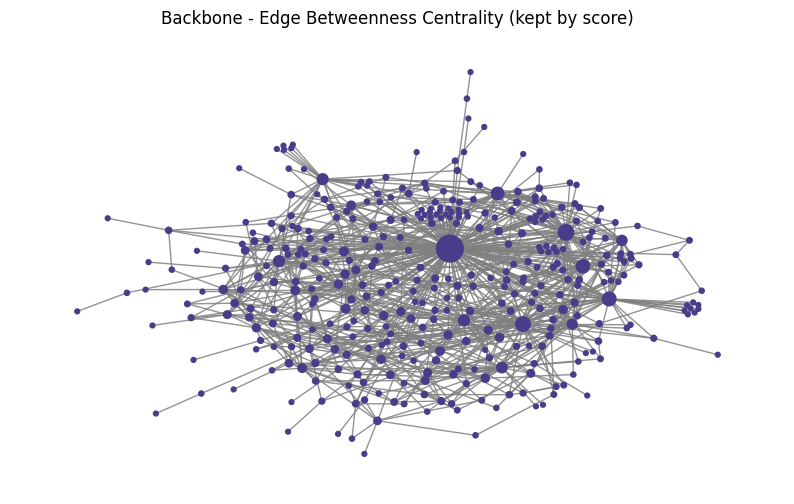

In [27]:
B1, sig1 = disparity_backbone(G1, alpha=0.10, top_q=0.95)
plot_backbone(B1, "Backbone - Edge Betweenness Centrality", sig1)

This backbone keeps the edges with the highest betweenness scores. These are the connections that lie on many shortest paths in the network. The plot shows that a smaller set of edges still holds most of the structure together, and a few recipes appear as more central than the rest. This gives a clearer view of the main connectivity patterns compared to the full dense network.

Calculating DF score...


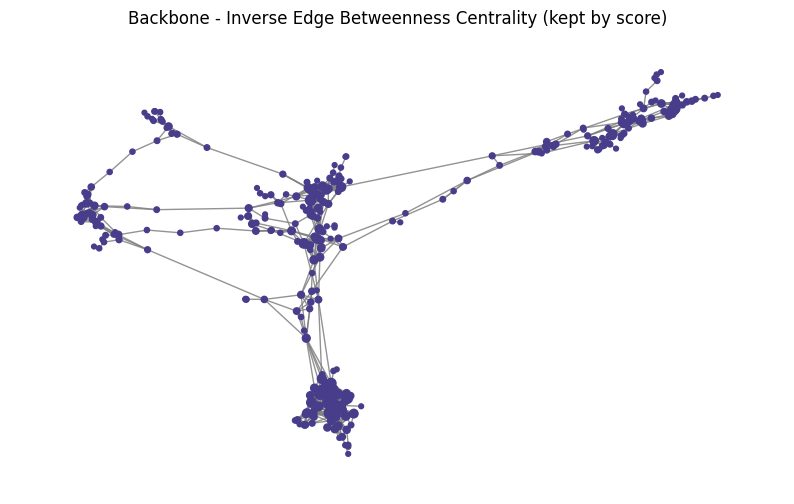

In [28]:
B2, sig2 = disparity_backbone(G2, alpha=0.10, top_q=0.95)
plot_backbone(B2, "Backbone - Inverse Edge Betweenness Centrality", sig2)

This backbone keeps edges with low betweenness. These edges represent more "local" connections rather than global bridges. The result is a clearer separation into smaller clusters of recipes, showing groups that are closely related through shared ingredients without the long-range links seen in the previous backbone.

Calculating DF score...


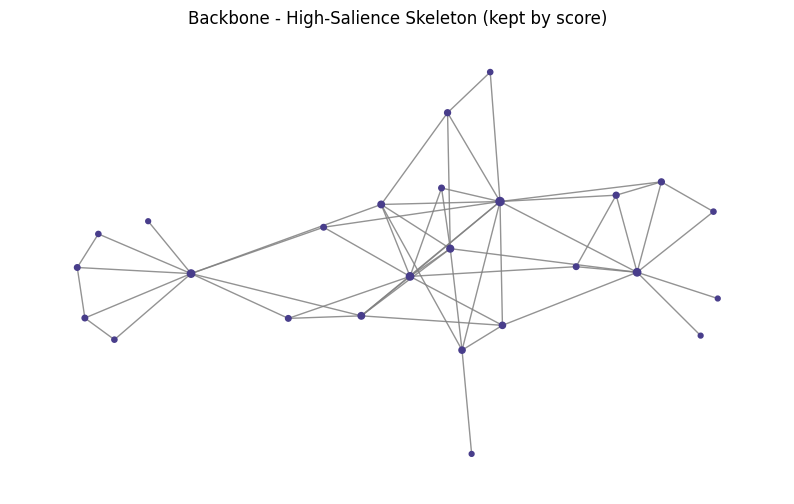

In [29]:
B3, sig3 = disparity_backbone(G3, alpha=0.10, top_q=0.95)
plot_backbone(B3, "Backbone - High-Salience Skeleton", sig3)

This backbone keeps only the edges with the highest salience scores. These are the connections that appear most consistently across important paths in the network. As a result, the backbone becomes very sparse and highlights only the strongest structural links. This gives a minimal view of how recipes are connected at the core level.

## Community detection

To understand the structure of the network beyond individual connections, we use community detection. This helps us find groups of recipes that are more closely related to each other based on shared ingredients. Here we will test different community detection algorithms and compare their results.

### Louvain method

The Louvain method is used to find communities by maximizing modularity, giving us groups of recipes that are strongly connected.

In [30]:
# make community detection on recipe graph
louvainC = nx.community.louvain_communities(G_recipes,seed=42)

print(f"Detected {len(louvainC)} communities using Lovain algorithm.")

# Compute modularity - 2 different approaches
M_louvain = nx.community.modularity(G_recipes, louvainC)

L = G_recipes.number_of_edges()
M_LA = 0

for nodes in louvainC:
    subgraph = G_recipes.subgraph(nodes)
    Lc = subgraph.number_of_edges()
    kc = sum(dict(G_recipes.degree(nodes)).values())
    M_LA += (Lc / L) - (kc / (2*L))**2

print(f"Modularity computed from: {M_LA:.4f}")
print(f"Modularity from NetworkX function: {M_louvain:.4f}")

# print communities
for i, com in enumerate(louvainC):
    print(f"Community {i+1}: {com}")

Detected 4 communities using Lovain algorithm.
Modularity computed from: 0.2436
Modularity from NetworkX function: 0.2554
Community 1: {'Buckwheat pancakes with smoked salmon and citrus cream cheese', 'Coffee and chocolate custard pots', 'Chocolate ripple cheesecake', 'Gluten-free banana bread', 'Chocolate brownie meringue cake with raspberry cream', 'Apple crumble cheesecake', 'Chocolate sponge cake', 'Camp doughnuts (jam eggy bread)', 'Chocolate olive oil cake', 'Chocolate cookies', "Nigel Slater's apple crumble with oats", 'Cannoli', 'Speculoos biscuit cake', 'Vegan chocolate and macadamia nut cookies', 'Chilli cheese toast', 'Cookie dough', 'Cheese, potato and onion pie', 'Easy cheese, leek and potato puff pie', "Hairy Bikers' Black Forest cake", 'Chocolate mousse cake', 'Chocolate and brandy shots', 'Breakfast bars', 'Air fryer apple, pear and raspberry crumble', 'Chocolate hazelnut cake', 'Pancakes', 'Chocolate fudge cake', 'Black Forest gâteau', 'Coconut chicken', 'Breakfast bur

In [31]:
## 10 main ingredients in each community
for i, community in enumerate(louvainC):
    ingredient_counter = Counter()
    for recipe_title in community:
        recipe_row = data[data['title'] == recipe_title].iloc[0]
        ingredient_counter.update(recipe_row['final_ingredients'])
    
    most_common_ingredients = ingredient_counter.most_common(10)
    print(f"Community {i+1} - Top 10 Ingredients: {most_common_ingredients}")

Community 1 - Top 10 Ingredients: [('egg', 83), ('butter', 77), ('caster sugar', 53), ('milk', 40), ('cream', 39), ('chocolate', 30), ('cocoa', 28), ('almond', 22), ('lemon', 21), ('water', 21)]
Community 2 - Top 10 Ingredients: [('onion', 106), ('garlic', 95), ('coriander', 74), ('sauce', 69), ('chicken', 57), ('rice', 49), ('tomato', 44), ('lime', 38), ('bean', 28), ('egg', 28)]
Community 3 - Top 10 Ingredients: [('olive oil', 128), ('garlic', 98), ('onion', 66), ('tomato', 64), ('lemon', 56), ('chicken', 46), ('parsley', 44), ('cheese', 30), ('butter', 29), ('cherry', 27)]
Community 4 - Top 10 Ingredients: [('butter', 25), ('onion', 25), ('olive oil', 14), ('beef', 13), ('parsley', 13), ('potato', 12), ('milk', 11), ('tomato puree', 11), ('mustard', 10), ('carrot', 10)]


The Louvain method finds 4 communities with a modularity of about 0.25, which suggests a meaningful but not extremely strong structure. Each group shows a clear theme in the types of recipes it contains, meaning the ingredient network naturally splits into meaningful clusters.

### Communities based on number of ingredients

Next, We try grouping recipes by how many ingredients they use to see if this simple measure forms meaningful communities compared to the network-based approach.

In [32]:
data_unique = data.drop_duplicates(subset=['title'])

# Assuming G_recipes nodes are recipe titles
n_ing_by_title = (
    data.groupby('title')['final_ingredients']
        .first()
        .apply(len)
)

num_ingredients_communities = { '3': set(), '4': set(), '5': set(), '6': set(),
                                '7': set(), '8': set(), '9': set(), '10': set(),
                                '11': set(), '12': set(), '13+': set() }

for title in G_recipes.nodes:   # iterate over graph nodes
    if title not in n_ing_by_title:
        continue  # or handle separately

    num_ingredients = n_ing_by_title[title]

    if num_ingredients == 3:
        num_ingredients_communities['3'].add(title)
    elif num_ingredients == 4:
        num_ingredients_communities['4'].add(title)
    elif num_ingredients == 5:
        num_ingredients_communities['5'].add(title)
    elif num_ingredients == 6:
        num_ingredients_communities['6'].add(title)
    elif num_ingredients == 7:
        num_ingredients_communities['7'].add(title)
    elif num_ingredients == 8:
        num_ingredients_communities['8'].add(title)
    elif num_ingredients == 9:
        num_ingredients_communities['9'].add(title)
    elif num_ingredients == 10:
        num_ingredients_communities['10'].add(title)
    elif num_ingredients == 11:
        num_ingredients_communities['11'].add(title)
    elif num_ingredients == 12:
        num_ingredients_communities['12'].add(title)
    elif num_ingredients >= 13:
        num_ingredients_communities['13+'].add(title)


In [33]:
print(f"Detected {len(num_ingredients_communities)} communities using number of ingredients.")

communities_for_modularity = [c for c in num_ingredients_communities.values() if c]

M_num_ingredients = nx.community.modularity(G_recipes, communities_for_modularity)
print(f"Modularity for number-of-ingredients communities: {M_num_ingredients:.4f}")

Detected 11 communities using number of ingredients.
Modularity for number-of-ingredients communities: 0.0015


Grouping recipes by the number of ingredients produces 11 predefined communities, but the modularity is extremely low. This means that the number of ingredients does not explain how recipes cluster in the network, and this type of grouping does not capture any meaningful structure compared to the Louvain communities.

### Communities based on first tag

As another simple baseline, we group recipes by their first tag. Tags are chosen by the recipe authors and may reflect style, category, or dietary type. Here we check whether these tag-based groups align with the ingredient network structure.

In [34]:
## Communities based on first tag
first_tag_communities = {}
for idx, row in data.iterrows():
    if row['title'] in G_recipes:
        first_tag = row['tags'].split('|')[0].strip().lower()
        if first_tag not in first_tag_communities:
            first_tag_communities[first_tag] = set()
        first_tag_communities[first_tag].add(row['title'])

print('Number of communities based on first tag:', len(first_tag_communities))

# Calculate modularity for first tag communities
communities_for_modularity = [c for c in first_tag_communities.values() if c]

M_first_tag = nx.community.modularity(G_recipes, communities_for_modularity)
print(f"Modularity for first-tag communities: {M_first_tag:.4f}")

Number of communities based on first tag: 137
Modularity for first-tag communities: 0.0127


In [35]:
# Communities with more than 3 recipes
print("Communities with more than 3 recipes:")
for tag, community in first_tag_communities.items():
    if len(community) > 3:
        print(f"Tag '{tag}' has {len(community)} recipes: {community}")
    

Communities with more than 3 recipes:
Tag 'quick' has 201 recipes: {'Healthy chickpea burgers', 'Bacon and white bean stew', 'Chicken and ricotta meatballs with spaghetti', 'Buttery leek and soy tagliatelle with sesame oil', 'Broccoli soup', 'Cheese, tomato and pesto toastie', 'Crispy new potatoes with summer vegetables', 'Energy balls', 'Air fryer classic burger', 'Air fryer chicken tikka masala', 'Beef stroganoff with sautéed potatoes', 'Chicken kebab wrap', 'Chocolate cookies', 'Air fryer chicken strips', 'Folded egg and rice with easy pantry sauce', 'Carrot, lentil and almond soup with wholemeal croûtons', 'Keralan prawn curry', 'Vegan chocolate and macadamia nut cookies', 'Easy beef and broccoli stir-fry', 'Bún chả inspired noodle bowl', 'Chilli cheese toast', 'Cold kimchi noodles', 'Cookie dough', 'Creamy celeriac soup', 'Chicken tikka salad', 'Crab linguine', 'Lamb and lentil burgers with Greek salad', 'Creamy pasta with broccoli and sweetcorn', 'Chickpeas with harissa and yoghu

Using the first tag to form communities results in 137 groups, but the modularity is very low (0.0127). This means that tag-based groups do not match the structure of the ingredient network. Most tags only apply to a few recipes, and even the larger tag groups contain recipes that are not closely connected in terms of shared ingredients. Tags are therefore too inconsistent and varied to create meaningful communities compared to the Louvain method.

### Subconclusion on communities

Based on the modularity results, the Louvain communities are the only grouping that captures meaningful structure in the recipe network. Therefore, we continue our analysis using the communities detected by the Louvain algorithm.

#### Visualization of communities

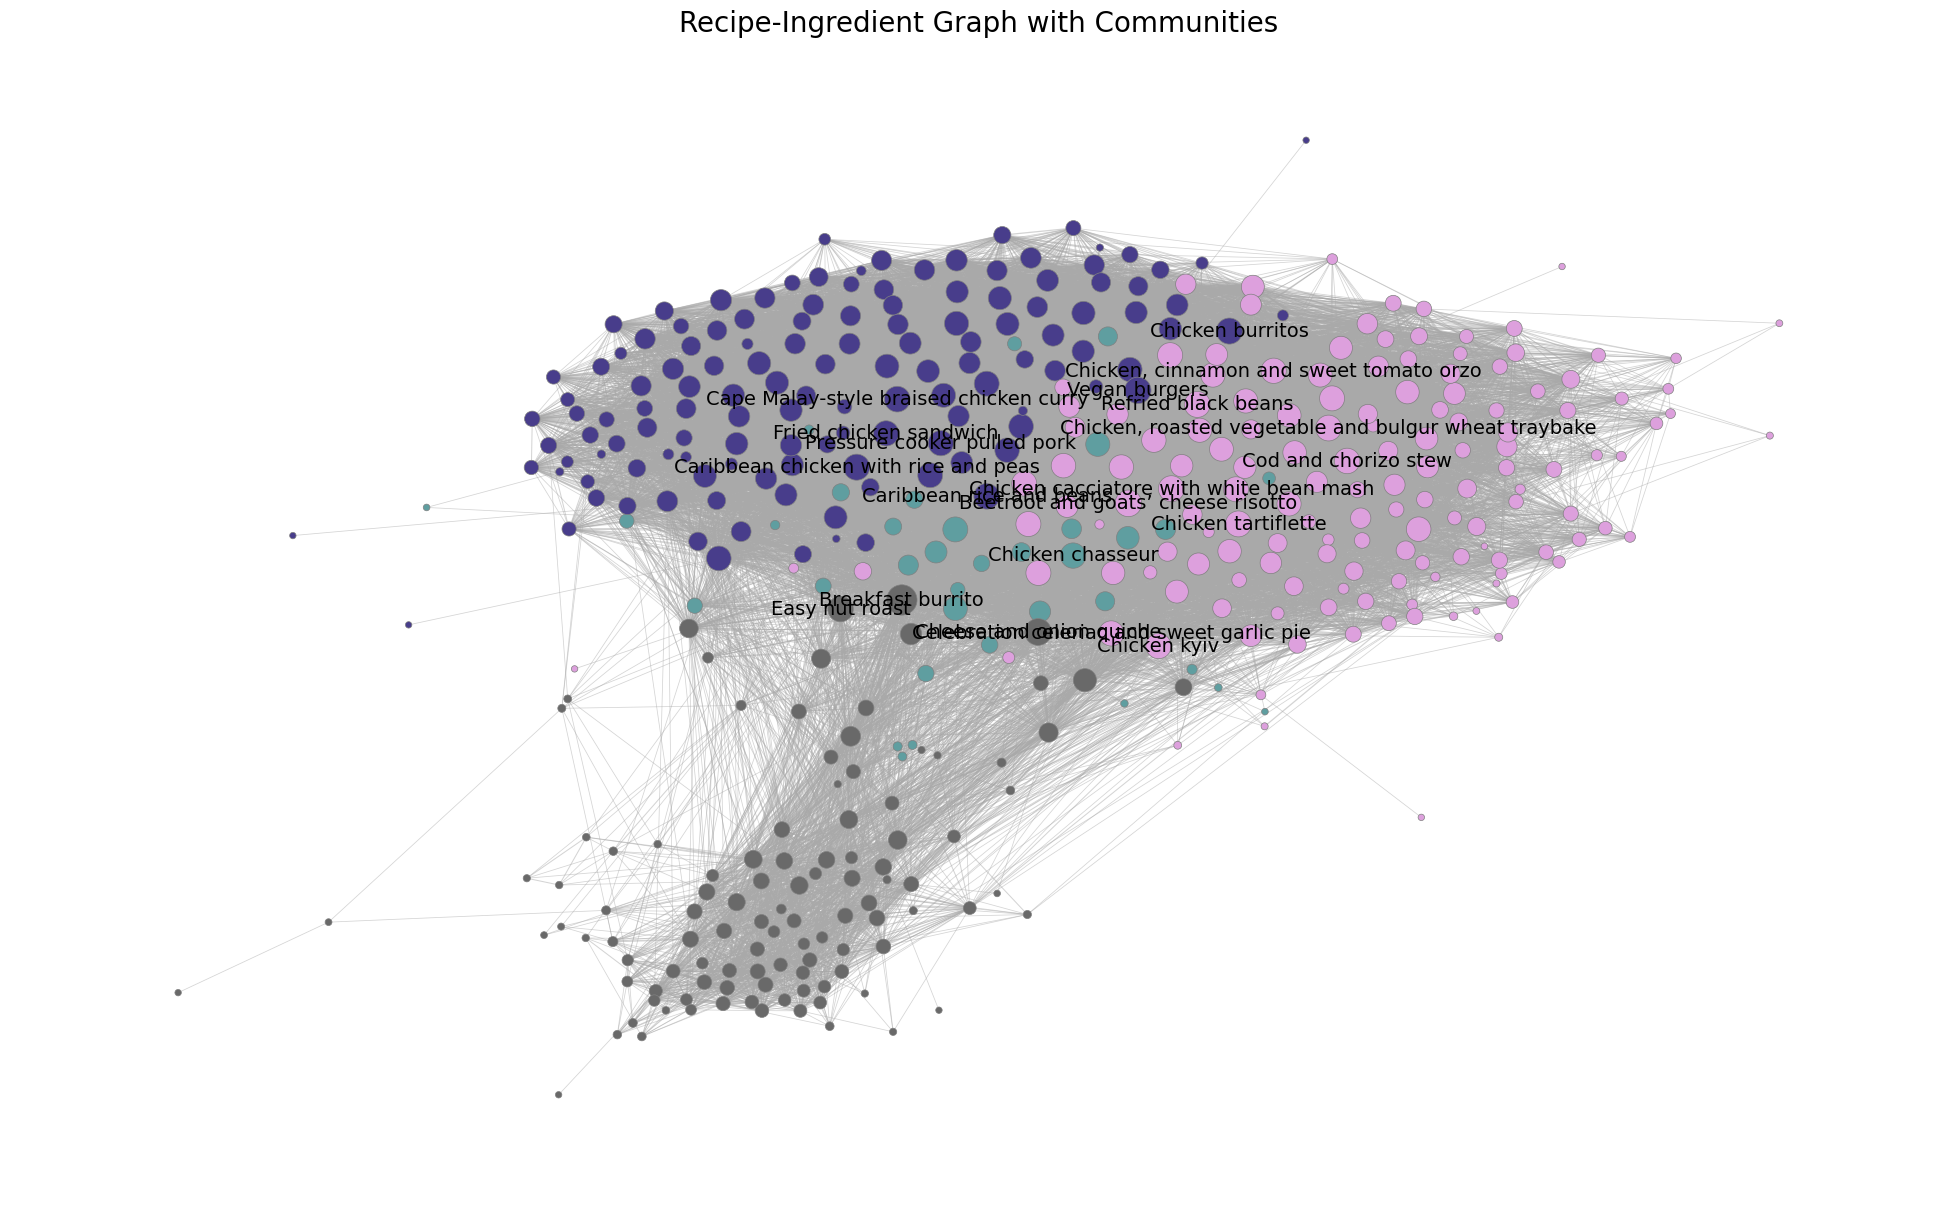

In [36]:
# Define custom colors for communities
community_colors = ['dimgrey', 'darkslateblue', 'plum', 'cadetblue']

# Map nodes to colors based on community
color_map = []
for node in G_recipes.nodes():
    for i, com in enumerate(louvainC):
        if node in com:
            # Use modulo in case there are more communities than colors
            color_map.append(community_colors[i % len(community_colors)])
            break

plt.figure(figsize=(25, 15))
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)

# --- Increase spacing between nodes ---
scale = 50  
pos = {node: (x * scale, y * scale) for node, (x, y) in pos.items()}

# Compute edge widths based on weight
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])

# Make edges thinner & lighter
edge_widths = edge_widths / edge_widths.max() * 2.0  
nx.draw_networkx_edges(
    G_recipes, pos,
    width=edge_widths,
    edge_color="darkgrey",
    alpha=0.5
)

# Node sizes based on degree
degrees = dict(G_recipes.degree())
node_sizes = [degrees[node] * 1.5 + 20 for node in G_recipes.nodes()]


# Draw nodes with custom colors and border
nx.draw_networkx_nodes(G_recipes, pos, node_color=color_map, node_size=node_sizes, 
                       linewidths=0.5, edgecolors='grey')

# Only label the top nodes by degree
top_n = 20  
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}

# Draw labels with smaller font
nx.draw_networkx_labels(G_recipes, pos, labels=labels, font_size=14)

plt.title("Recipe-Ingredient Graph with Communities", fontsize=20)
plt.axis("off")
plt.show()


The visualization shows the recipe network with the four Louvain communities highlighted in different colors. The communities form clear clusters, where recipes inside each group are closely connected through shared ingredients. Although there are many edges, the colored clusters remain visible, confirming that the Louvain method captures meaningful structure in the network. A few recipes sit between clusters or on the edges, showing weaker connections.

In [37]:
# we map the communities with recipes
community_map = {}

for i, com in enumerate(louvainC):
    for title in com:
        community_map[title] = f"Community {i+1}"

data['community'] = data['title'].map(community_map)        

# Sentiment analysis
We perform sentiment analysis on the recipes to see whether the communities differ in how positively or negatively their texts are written. We calculate sentiment scores for the description, method, and tags of each recipe.

First, we define a function to calculate sentiment scores using a dataset of positive and negative words. The function counts how many positive and negative words appear in a given text and computes a sentiment score based on their difference.

In [38]:
# sentiment analysis - happiness dataset to create score 
happiness_df = pd.read_csv("happiness_sentiment.txt", sep="\t")

In [39]:
# function to calculate sentiment score based on tokens
def sentiment(tokens, word_list = happiness_df):

    tokens = [token.lower() for token in tokens]

    token_series = pd.Series(tokens)
    token_freq = token_series.value_counts().reset_index()
    token_freq.columns = ['word', 'frequency']

    if token_freq.empty:
        return None
    
    words_in_list = word_list[word_list['word'].isin(tokens)]

    merged = pd.merge(token_freq, words_in_list, left_on='word', right_on='word')
    sentiment_score = sum(merged['frequency'] * merged['happiness_average'])/sum(merged['frequency'])
    
    return sentiment_score

Then we have to clean the text data by removing punctuation and converting everything to lowercase and tokenizing it.

In [40]:
# we want to calculate sentiment on both description,method,tags and overall
data['tokens_des'] = data['description'].str.split()
data['tokens_des'] = data['tokens_des'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_met'] = data['method'].str.split()
data['tokens_met'] = data['tokens_met'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_tag'] = data['tags'].str.split()
data['tokens_tag'] = data['tokens_tag'].apply(lambda x: [word for word in x if word.isalpha()])  
data['tokens_all'] = data.apply(lambda row: row['tokens_des'] + row['tokens_met'] + row['tokens_tag'],axis=1)
data['sentiment_des'] = data['tokens_des'].apply(lambda x: sentiment(x))
data['sentiment_met'] = data['tokens_met'].apply(lambda x: sentiment(x))
data['sentiment_tag'] = data['tokens_tag'].apply(lambda x: sentiment(x))
# Overall sentiment: 
data['sentiment_all'] = data['tokens_all'].apply(sentiment)
for idx, row in data.iterrows():
    if row['title'] in G_recipes.nodes:
        G_recipes.nodes[row['title']]['sentiment_des'] = row['sentiment_des']
        G_recipes.nodes[row['title']]['sentiment_met'] = row['sentiment_met']
        G_recipes.nodes[row['title']]['sentiment_tag'] = row['sentiment_tag']
        G_recipes.nodes[row['title']]['sentiment_all'] = row['sentiment_all']


Next, we compute sentiment scores for the description, method, and tags of each recipe using the defined function for each community.

In [41]:
# associate comumunities with sentiment scores
community_sentiments = []
for com in louvainC:
    com_sentiments_des = data[data['title'].isin(com)]['sentiment_des'].dropna()
    com_sentiments_met = data[data['title'].isin(com)]['sentiment_met'].dropna()
    com_sentiments_tag = data[data['title'].isin(com)]['sentiment_tag'].dropna()
    com_sentiments_all = data[data['title'].isin(com)]['sentiment_all'].dropna()
    if not com_sentiments_des.empty:
        avg_sentiment_des = com_sentiments_des.mean()
        avg_sentiment_met = com_sentiments_met.mean()
        avg_sentiment_tag = com_sentiments_tag.mean()
        avg_sentiment_all = com_sentiments_all.mean()
    else:
        avg_sentiment_des = None
        avg_sentiment_met = None
        avg_sentiment_tag = None
        avg_sentiment_all = None
    community_sentiments.append((com, avg_sentiment_des,avg_sentiment_met,avg_sentiment_tag,avg_sentiment_all))

for i, (com, avg_sentiment_des,avg_sentiment_met,avg_sentiment_tag,avg_sentiment_all) in enumerate(community_sentiments):
    print(f"Community {i+1} Average Sentiment for different textbits - descrip: {avg_sentiment_des} - method: {avg_sentiment_met} - tag: {avg_sentiment_tag} - overall: {avg_sentiment_all}")


Community 1 Average Sentiment for different textbits - descrip: 5.6556568647585115 - method: 5.386862205407073 - tag: 6.602010107911247 - overall: 5.607270172044666
Community 2 Average Sentiment for different textbits - descrip: 5.576776143997168 - method: 5.3705793014163 - tag: 6.406679962865625 - overall: 5.583550311751068
Community 3 Average Sentiment for different textbits - descrip: 5.610455906796463 - method: 5.370729873756969 - tag: 6.501470681668575 - overall: 5.631020502401816
Community 4 Average Sentiment for different textbits - descrip: 5.6068187985990665 - method: 5.354689304422151 - tag: 6.400933199879477 - overall: 5.543190129357544


The average sentiment scores are very similar across all four communities. Description and method text show almost no difference between groups, and the overall sentiment is nearly the same. The tag sentiment is slightly higher in all communities, but Community 1 has the highest tag score. Overall, this suggests that the ingredient-based communities do not differ much in how positively or negatively the recipes are written.

## Box plots

To gain insights on communities and their sentiment scores together with user rating we create box plots for each community.

In [42]:
data_boxplot = data.copy()
data_boxplot['community'] = data_boxplot['title'].map(community_map)
data_boxplot = data_boxplot.dropna(subset=['community'])

# Variable names
types = ['sentiment_des', 'sentiment_met', 'sentiment_tag', 'ratingValue']

# Nice display names for subplot titles
titles = {
    'sentiment_des': 'Description Sentiment',
    'sentiment_met': 'Method Sentiment',
    'sentiment_tag': 'Tag Sentiment',
    'ratingValue': 'Rating'
}

# Create 2×2 subplot grid with tighter spacing
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[titles[t] for t in types],
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

# Mapping from index to subplot position
positions = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}

# Add one boxplot per subplot
for i, t in enumerate(types):
    row, col = positions[i]
    fig.add_trace(
        go.Box(x=data_boxplot['community'], y=data_boxplot[t], name=t),
        row=row, col=col
    )

fig.update_layout(
    height=900,
    width=1100,
    showlegend=False
)

fig.show()


The boxplots confirm the earlier average sentiment results. The distributions for description and method sentiment overlap almost completely across communities, showing no meaningful differences. Tag sentiment again shows the most variation, with Community 1 slightly higher, but the overall patterns remain very similar. The rating distributions also line up closely, supporting the conclusion that the communities differ in ingredients but not in writing style or user ratings.

## Outliers

The boxplots show a few outliers in the sentiment scores. To understand these better, we extract the recipes with the highest and lowest sentiment values in tag category, since this was the most diverse and look at them more closely.

In [43]:
all_outlier_titles = set()
# choose from 'sentiment_tag', 'sentiment_met' , 'sentiment_des' , 'sentiment_all'
chosenSentType = 'sentiment_tag'
for i, com in enumerate(louvainC):
    community_name = f"Community {i+1}"

    # Filter data for this community
    com_data = data_boxplot[data_boxplot['community'] == community_name]

    if com_data.empty:
        print(f"{community_name} — No data found")
        continue

    # Compute IQR thresholds
    q1 = com_data[chosenSentType].quantile(0.25)
    q3 = com_data[chosenSentType].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Get outliers
    outliers = com_data[(com_data[chosenSentType] < lower_bound) | 
                        (com_data[chosenSentType] > upper_bound)]

    print(f"{community_name} Outliers:")
    print(outliers[['title', chosenSentType]])

    # Save the outlier titles
    all_outlier_titles.update(outliers['title'])


Community 1 Outliers:
             title  sentiment_tag
336  Bakewell tart       6.029333
Community 2 Outliers:
                  title  sentiment_tag
312  Budget beans pulao       5.840938
Community 3 Outliers:
          title  sentiment_tag
223  Fish cakes       5.951892
Community 4 Outliers:
Empty DataFrame
Columns: [title, sentiment_tag]
Index: []


Each of the first three communities has one recipe with unusually low tag sentiment, while Community 4 has none. These are isolated cases and do not affect the overall similarity in sentiment across communities.

### Visualization of outliers

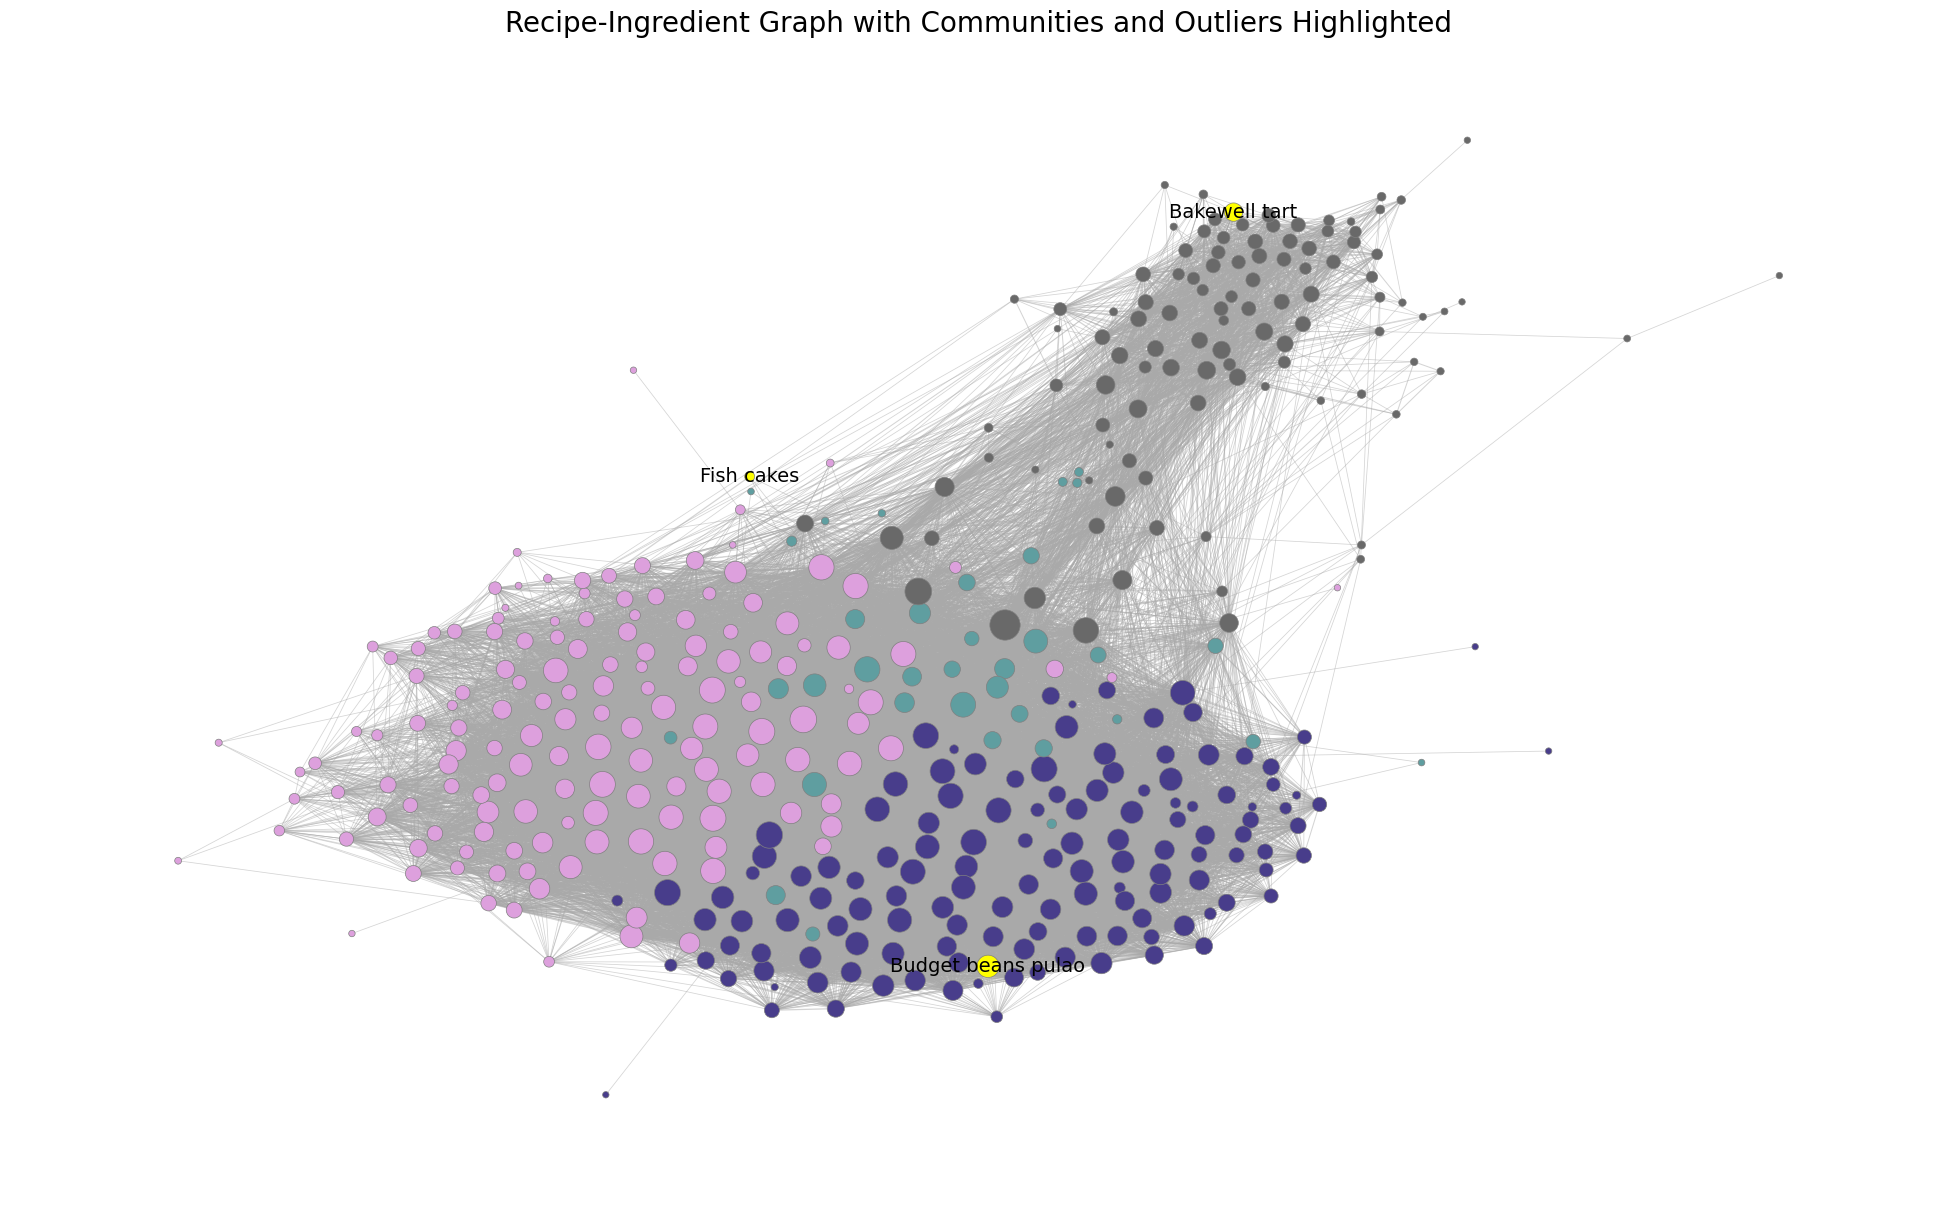

In [44]:
# --- Colors for communities (same as before) ---
community_colors = ['dimgrey', 'darkslateblue', 'plum', 'cadetblue']

# Degrees for size
degrees = dict(G_recipes.degree())

color_map = []
node_sizes = []

for node in G_recipes.nodes():
    # base: community color
    node_color = 'lightgrey'
    for i, com in enumerate(louvainC):
        if node in com:
            node_color = community_colors[i % len(community_colors)]
            break

    # base size from degree
    size = degrees[node] * 1.5 + 20

    # override if node is an outlier
    if node in all_outlier_titles:
        node_color = 'yellow'
        size = size * 2       # make outliers bigger

    color_map.append(node_color)
    node_sizes.append(size)

plt.figure(figsize=(25, 15))

# If you want EXACT same layout as previous plot, reuse the same `pos`.
# Otherwise, recompute with same settings:
pos = nx.forceatlas2_layout(G_recipes, max_iter=2000)
scale = 50
pos = {node: (x * scale, y * scale) for node, (x, y) in pos.items()}

# --- Edges (same style as community plot) ---
edge_widths = np.array([d['weight'] for _, _, d in G_recipes.edges(data=True)])
edge_widths = edge_widths / edge_widths.max() * 2.0

nx.draw_networkx_edges(
    G_recipes, pos,
    width=edge_widths,
    edge_color="darkgrey",
    alpha=0.5
)

# --- Nodes with community colors + highlighted outliers ---
nx.draw_networkx_nodes(
    G_recipes,
    pos,
    node_color=color_map,
    node_size=node_sizes,
    linewidths=0.5,
    edgecolors='grey'
)

# Label only outliers (so plot doesn’t get messy)
labels = {node: node for node in all_outlier_titles if node in G_recipes.nodes()}
nx.draw_networkx_labels(G_recipes, pos, labels=labels, font_size=14)

plt.title("Recipe-Ingredient Graph with Communities and Outliers Highlighted", fontsize=20)
plt.axis("off")
plt.show()


The plot shows the recipe network with communities colored and the sentiment outliers highlighted in yellow. The outlier recipes appear in different parts of the network, showing that unusual sentiment values do not cluster within any one community. This shows that unusual sentiment values occur at the recipe level and are not tied to specific ingredient-based communities.

## Analysis of sentiment and other measures

In this section, we check whether tag sentiment or other recipe characteristics relate to the structure of the network or to user ratings.

In [42]:
# Compute assortativity
r = nx.attribute_assortativity_coefficient(G_recipes, chosenSentType)
print(f"Assortativity (sentiment): {r:.5f}")

Assortativity (sentiment): -0.00353


The assortativity for sentiment is almost zero, meaning recipes with similar sentiment scores are no more likely to be connected than recipes with different scores. In other words, sentiment does not play any role in how recipes link through shared ingredients.

In [43]:
data['community'] = data['title'].map(community_map)
df_plot = data.dropna(subset=['sentiment_des', 'ratingValue', 'community'])

fig = px.scatter(
    df_plot,
    x='sentiment_des',
    y='ratingValue',
    hover_name='title',
    color='community',  
    title='Sentiment vs RatingValue by Community',
    labels={
        'sentiment_des': 'Sentiment Score',
        'ratingValue': 'Rating',
        'community': 'Community'
    }
)
fig.show()


The scatter plot shows no clear relationship between sentiment and rating. Recipes with both low and high sentiment scores receive similar ratings, and this pattern is the same across all four communities. This supports the earlier result that sentiment does not influence how users rate the recipes.

In [44]:

df_plot2 = data.dropna(subset=['degree', 'ratingValue', 'community'])

fig = px.scatter(
    df_plot2,
    x='degree',
    y='ratingValue',
    hover_name='title',
    color='community',  
    title='Node Degree vs RatingValue',
    labels={'degree': 'Node Degree', 'ratingValue': 'Rating',
        'community': 'Community'},
    #color_discrete_sequence=['orange']
)
fig.show()


The plot shows that recipes with both low and high node degree appear across almost the full rating range, so there is no clear relationship between how well a recipe is connected in the network and how highly it is rated. Most recipes cluster around ratings 4–5 regardless of degree. There are a few recipes with very high degree, but these do not consistently receive higher ratings, as they follow the same general pattern as the rest. This means we cannot conclude that using many common ingredients leads to better ratings.

Overall, the plot suggests that ratings are mostly independent of both sentiment and connectivity in the ingredient network.

In [45]:
df_plot2 = data.dropna(subset=['ratingCount', chosenSentType])

fig = px.scatter(
    df_plot2,
    x='ratingCount',
    y=chosenSentType,
    hover_name='title',
    title='Rating count vs sentiment',
    labels={'ratingCount': 'RatingCount', chosenSentType: 'sentiment'},
    color_discrete_sequence=['orange']
)
fig.show()


Finally, we check whether sentiment relates to the number of ratings in a recipe. The plot shows that sentiment does not depend on how many ratings a recipe has. Most recipes have very few ratings, and within this range the sentiment values vary in the same way as recipes with many ratings. Even recipes with very high rating counts do not stand out in sentiment. This confirms that sentiment is not linked to how popular a recipe is. However this was also our observation from the initial exploration of the data.

## TF-IDF and Wordclouds

Using TF-IDF and word clouds, we can highlight the words that appear most often within each community compared to the others. This helps us see which ingredients or terms are most characteristic for each group of recipes.

In [46]:
#prepare full text 
data['full_text'] = (
    data['description'].fillna('') + ' ' +
    data['method'].fillna('') + ' ' +
    data['tags'].fillna('')
)
# used to prepare text for tf-idf 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['full_text_clean'] = data['full_text'].apply(clean_text)

# maps com and their respective texts
community_docs = {}

for i, com in enumerate(louvainC):
    members = list(com)
    texts = data[data["title"].isin(members)]["full_text_clean"].dropna().tolist()
    community_docs[f"Community_{i+1}"] = " ".join(texts)


In [47]:
# we now compute tf-idf using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

communities_list = list(community_docs.keys())
docs_list = list(community_docs.values())

tfidf_matrix = vectorizer.fit_transform(docs_list)
feature_names = np.array(vectorizer.get_feature_names_out())


Common words across all communities: ['season', 'air', 'party', 'pan', 'pepper', 'cook', 'stir', 'gently', 'egg', 'set', 'brown', 'gas', 'dairy', 'turn', 'oil', 'low', 'best', 'transfer', 'nut', 'vegetarian', 'family', 'quick', 'schema', 'use', 'minutes', 'vegetariandiet', 'water', 'add', 'large', 'favourites'] ...


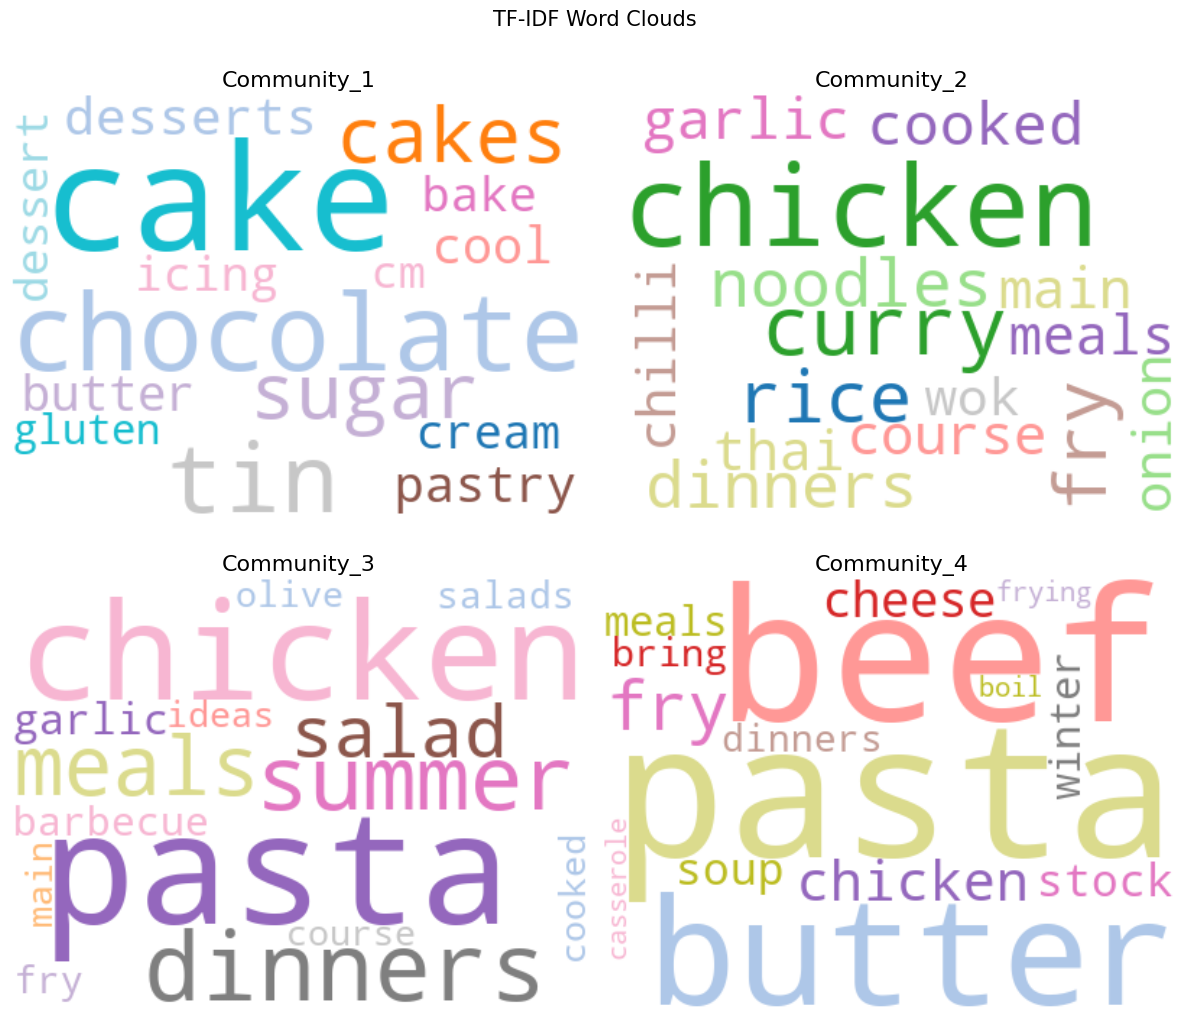

In [48]:
raw_words = {}
for i, comm in enumerate(communities_list):
    row = tfidf_matrix[i].toarray().flatten()
    idx = row.argsort()[::-1][:200]
    raw_words[comm] = set(feature_names[idx])

# Find words appearing in *all* communities

common_words = set.intersection(*raw_words.values())
print("Common words across all communities:", list(common_words)[:30], "...")

# extract common words per communitiy (15)
top_words_per_comm = {}
for i, comm in enumerate(communities_list):
    row = tfidf_matrix[i].toarray().flatten()
    idx_sorted = row.argsort()[::-1]

    filtered = [(feature_names[j], row[j]) 
                for j in idx_sorted 
                if feature_names[j] not in common_words] # if not in common words

    top_words_per_comm[comm] = filtered[:15]   # top 15 after filtering

# word cloud time 
n_comms = len(top_words_per_comm)
n_cols = 2
n_rows = int(np.ceil(n_comms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, (comm, words) in enumerate(top_words_per_comm.items()):
    word_freq = dict(words)
    wc = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='tab20'
    ).generate_from_frequencies(word_freq)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(comm, fontsize=16)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("TF-IDF Word Clouds", fontsize=15, y=1.04)
plt.show()



The TF-IDF word clouds highlight the words that are most distinctive for each community. Community 1 is dominated by baking-related terms such as cake, chocolate, and sugar, reflecting its many desserts. Community 2 shows words like chicken, curry, rice, and noodles, matching its focus on Asian/spicy dishes. Community 3 includes terms such as pasta, salad, and summer, which fits its lighter chicken- and vegetable-based meals. Community 4 features words like beef, pasta, butter, and soup, consistent with hearty beef-based dishes. Overall, the word clouds confirm the differences between the ingredient-based communities and align well with the patterns seen earlier.